In [1]:
using ESOM
using DataFrames
using CSV
using Statistics
using Plots
using StaticArrays
using Dates

In [2]:
file = "/Users/jpnousu/SpaFHy_RUNS/hyytiala/forcing/FORCING.csv"
df = CSV.read(file, DataFrame; select=[1,2])

n = 7  # Window size
t_mean = df.t_mean
t_peat1 = [clamp(mean(t_mean[max(1, i-Int(floor(n/2))):min(end, i+Int(floor(n/2)))]), 0, Inf) for i in 1:length(t_mean)]
df.t_peat1 = t_peat1;

In [3]:
f = ESOM.create_interpolation_functions();
params = ESOM.create_parameters();
initial_masses = ESOM.initialize_storages(params);
B = ESOM.create_initial_B_matrix(initial_masses);
println(B)

[0.0, 0.0, 0.3, 0.3, 0.6, 0.6, 4.199999999999999, 31.8, 47.4, 47.7, 0.0]


In [4]:
# Set the grid size
nx = 1
ny = 1

# Initialize an empty array to store results as StaticVector
results = SVector[]  # Empty array to store SVector elements

# Iterate through all rows in the DataFrame
for i in 1:nrow(df)
    # Extract t_mean and t_peat1 for the current row
    tmean_value = df.t_mean[i]
    tpeat1_value = df.t_peat1[i]
    times = df.time[i]

    # Print the current date to track progress
    #println("Processing date: ", df.time[i])
    
    # Loop over nx and ny
    for x in 1:nx
        for y in 1:ny
            # Create the forcing object
            if month.(times) == 9 && day.(times) == 1
                L0nw = 1
                L0w = 1
            else
                L0nw = 0
                L0w = 0
            end

            forc = ESOM.Forcing(L0w, L0nw, tmean_value, tpeat1_value, tpeat1_value, tpeat1_value, 0.5, 0.5, 0.5, 0.5)
            
            # Compute rates
            rates = ESOM.calculate_rates(forc, params, f)
            
            # Construct A matrix
            A = ESOM.construct_A_matrix(params, rates)
            
            B = SVector(L0nw, L0w, B[3:end]...)
            # Compute A * B
            B = ESOM.compute_A_x_B(A, B)
            
            # Append the result (SVector B) as a new row to the results array
            push!(results, B)  # Add the SVector B as a new row to results
        end
    end
end

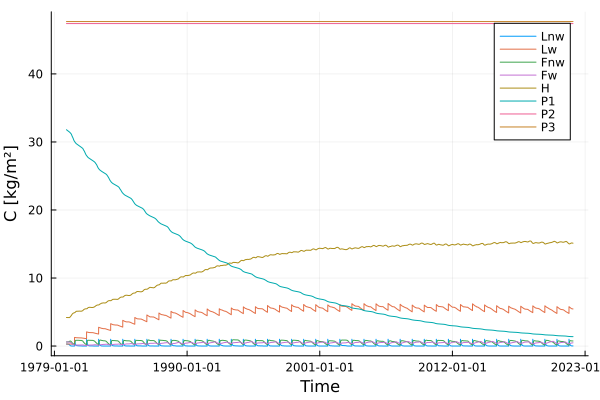

In [5]:
labels = ["Lnw", "Lw", "Fnw", "Fw", "H", "P1", "P2", "P3"]

p = plot(df.time, [B[3] for B in results], label=labels[1], xlabel="Time", ylabel="C [kg/m²]")

for i in 4:length(results[1])-1  # Start from 4 to exclude first two elements, end at second last element
    # Extract the i-th element of each vector
    values = [B[i] for B in results]
    
    # Plot this value over time with the corresponding label
    plot!(p, df.time, values, label=labels[i-2])  # Adjust for 0-based index in labels
end

# Display the plot (explicitly call show() if needed)
display(p)